# Apply theta, psi, S & save .hdf5's: 
1. Load generated volume fraction maps (.txt or .npy files)
2. Apply orientation parameters
3. Save .hdf5
4. Visualize .hdf5 / model

In [2]:
### Imports
import pathlib
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap
import re
from scipy.ndimage import binary_erosion, distance_transform_edt, label, zoom
from NRSS.morphology import Morphology, Material, OpticalConstants
from NRSS.writer import write_materials, write_hdf5, write_config
from NRSS.visualizer import morphology_visualizer



### Define paths:
rootPath = pathlib.Path('/nsls2/users/alevin/rsoxs_suite')
simsPath = rootPath.joinpath('imgs_analysis/sim_runs')
optsPath = rootPath.joinpath('nexafs_analysis/optical_constants')

### Colormaps
colors1 = plt.cm.PuBuGn_r(np.linspace(0., 1., 128))
colors2 = plt.cm.PuBuGn(np.linspace(0., 1., 128))
colors = np.vstack((colors1, colors2))
mirrored_orientation_map = LinearSegmentedColormap.from_list('my_coloirmap', colors)
mirrored_orientation_map.set_bad(color='r')

sequential_map = plt.cm.YlGnBu_r.copy()

CyRSoXS
Size of Real               : 4
Maximum Number Of Material : 32
 __________________________________________________________________________________________________
|                                 Thanks for using CyRSoXS                                        |
|--------------------------------------------------------------------------------------------------|
|  Copyright          : Iowa State University                                                      |
|  License            : NIST                                                                       |
|  Acknowledgement    : ONR MURI                                                                   |
|                                                                                                  |
|  Developed at Iowa State University in collaboration with NIST                                   |
|                                                                                                  |
|  Please cite the fol

In [3]:
def list_files(filter_string, path):
    return sorted([f.name for f in path.glob(filter_string)])

def get_file_path(filter_string, path):
    return list(path.glob(filter_string))[0]

def split_letters_numbers(string):
    pattern = r'(\d+\.\d+|\d+|\D+)'
    split_string = re.findall(pattern, string)
    return split_string

def apply_psi_orientation(volume_fraction, orient, threshold=0.5):
    # Create a binary image for segmentation by thresholding
    binary_image = (volume_fraction > threshold).astype(np.uint8)
    
    # Perform a distance transform on the binary image
    dist_transform = distance_transform_edt(binary_image)
    
    # Perform image segmentation using scipy's label
    labels_im, num_labels = label(binary_image)

    # Calculate the gradient of the volume fraction in the segment
    grad_y, grad_x = np.gradient(volume_fraction)

    # Calculate theta and psi angles based on gradient direction
    # atan2 returns angle in range (-pi, pi) which maps to (0, 2pi) in orientation
    perp_angles_map = np.arctan2(grad_y, grad_x)
    para_angles_map = np.arctan2(grad_x, grad_y)
    material_angles_map = np.zeros_like(volume_fraction)
    
    # # Perform a distance transform on the binary image and try to isolate center ridges of domains, choose values to set angles
    # center_pixel_mask = dist_transform>8
    # # perp_angles_map[center_pixel_mask] = np.nan
    # para_angles_map[center_pixel_mask] = np.nan

    # Mix para and perp angles map into a material angles map
    for l in range(0, num_labels):  # start at 1 to ignore background
        # Identify segment
        segment = (labels_im == l)    
        if np.mean(binary_image[segment]) == 1:  
            if orient==None or orient=='perp':
                material_angles_map[segment] = perp_angles_map[segment]
            elif orient=='para':
                material_angles_map[segment] = para_angles_map[segment]
            # pass
        # elif np.mean(binary_image[segment]) == 0:  # Second half of segments
        #     # material_angles_map[segment] = para_angles_map[segment]
        #     pass
            
    return binary_image, dist_transform, material_angles_map

### Very basic plotting functions: 
def plot_arr(material=1):
    plt.close('all')
    fig, axs = plt.subplots(1,3)
    fig.set(size_inches=(12,9), dpi=120)
    
    if material==1:
        fig.suptitle('Material 1', y=0.7, fontsize=14)

        vfrac_im = axs[0].imshow(mat1_vfrac, origin='lower', cmap=sequential_map)
        axs[0].set_title("Volume Fraction", fontsize=10)
        axs[1].imshow(mat1_binary_image, origin='lower', cmap=sequential_map)
        axs[1].set_title('Binarized Volume Fraction Image', fontsize=10)
        axs[2].imshow(mat1_dist_transform/np.max(mat1_dist_transform), origin='lower', cmap=sequential_map)
        axs[2].set_title('Normalized Domain Center Distances', fontsize=10)
        
    elif material==2:
        fig.suptitle('Material 2', y=0.7, fontsize=14)

        vfrac_im = axs[0].imshow(mat2_vfrac, origin='lower', cmap=sequential_map)
        axs[0].set_title("Volume Fraction", fontsize=10)
        axs[1].imshow(mat2_binary_image, origin='lower', cmap=sequential_map)
        axs[1].set_title('Binarized Volume Fraction Image', fontsize=10)
        axs[2].imshow(mat2_dist_transform/np.max(mat1_dist_transform), origin='lower', cmap=sequential_map)
        axs[2].set_title('Normalized Domain Center Distances', fontsize=10)

    fig.subplots_adjust(wspace=0.3)
    cax = fig.add_axes((0.92, 0.37, 0.015, 0.25))
    fig.colorbar(vfrac_im, cax = cax)

    plt.show()
    
def plot_psi(material=1, leftbottom=0, topright=-1):
    plt.close('all')
    fig, axs = plt.subplots(1, 2)
    fig.set(size_inches=(8,4), dpi=120)
    
    if material==1:
        fig.suptitle('Material 1 Array Checks')

        vfracs = axs[0].imshow(mat1_vfrac[leftbottom:topright, leftbottom:topright], origin='lower', cmap=plt.cm.YlGnBu_r)
        axs[0].set(title='Volume Fraction', xlabel='pixels', ylabel='pixels')
        angles = axs[1].imshow(np.abs(mat1_angles_map[leftbottom:topright, leftbottom:topright]), origin='lower', cmap=mirrored_orientation_map)
        axs[1].set_title(f'Psi Orientation Map: Parallel') if mat1_orient=='para' else axs[1].set_title(f'Psi Angles Map: Perpendicular')
        axs[1].set(xlabel='pixels')
        
    elif material==2:
        fig.suptitle('Material 2 Array Checks')

        vfracs = axs[0].imshow(mat2_vfrac[leftbottom:topright, leftbottom:topright], origin='lower', cmap=plt.cm.YlGnBu_r)
        axs[0].set(title='Volume Fraction', xlabel='pixels', ylabel='pixels')
        angles = axs[1].imshow(np.abs(mat2_angles_map[leftbottom:topright, leftbottom:topright]), origin='lower', cmap=mirrored_orientation_map)
        axs[1].set_title(f'Psi Orientation Map: Parallel') if mat2_orient=='para' else axs[1].set_title(f'Psi Angles Map: Perpendicular')
        axs[1].set(xlabel='pixels')
        
    # fig.subplots_adjust(wspace=0.4)        
    cax_vfracs = fig.add_axes((0.03, 0.18, 0.02, 0.64))
    cax_angles = fig.add_axes((0.92, 0.18, 0.02, 0.64))
    cbar_vfracs = fig.colorbar(vfracs, cax=cax_vfracs, ticks=[])
    fig.colorbar(angles, cax=cax_angles, label='Abs. Value of Angle [radians]')    
    plt.show()

In [4]:
a = 1.0
eps = 1.0
shape = '250pix'
steps = 600

list_files(f'*a{a}*eps{eps}*{shape}*{steps}steps*', simsPath)

['D1.0_a1.0_eps1.0_250pix_375size_0.5m_600steps_1']

In [5]:
params = {}

raw_string = list_files(f'*a{a}*eps{eps}*{shape}*{steps}steps*', simsPath)[0]
for string in raw_string.split('_'):
    split_string = split_letters_numbers(string)
    if len(split_string)==2:
        try:
            v = float(split_string[1]) if '.' in split_string[1] else int(split_string[1])
            k = split_string[0]
        except ValueError:
            v = float(split_string[0]) if '.' in split_string[0] else int(split_string[0])
            k = split_string[1]  
        params[k] = v
    else:
        v = split_string[0]
        params['counter'] = v

simPath = simsPath.joinpath(raw_string)
display(params)
display(list_files('*', simPath))

{'D': 1.0,
 'a': 1.0,
 'eps': 1.0,
 'pix': 250,
 'size': 375,
 'm': 0.5,
 'steps': 600,
 'counter': '1'}

['.ipynb_checkpoints',
 'BHJ.hdf5',
 'BHJ_0steps.png',
 'BHJ_0steps.txt',
 'BHJ_100steps.png',
 'BHJ_100steps.txt',
 'BHJ_10steps.png',
 'BHJ_10steps.txt',
 'BHJ_200steps.png',
 'BHJ_200steps.txt',
 'BHJ_300steps.png',
 'BHJ_300steps.txt',
 'BHJ_30steps.png',
 'BHJ_30steps.txt',
 'BHJ_400steps.png',
 'BHJ_400steps.txt',
 'BHJ_500steps.png',
 'BHJ_500steps.txt',
 'BHJ_50steps.png',
 'BHJ_50steps.txt',
 'BHJ_600steps.png',
 'BHJ_600steps.txt',
 'CyRSoXS.log',
 'HDF5',
 'Material1.txt',
 'Material2.txt',
 'config.txt',
 'cyrsoxs.1339059.out',
 'cyrsoxs.1339156.out',
 'cyrsoxs_job.sh']

In [6]:
volume_fraction = np.loadtxt(get_file_path(f'*600steps*.txt', simPath))

mat1_vfrac = volume_fraction
mat2_vfrac = 1-volume_fraction

zoom_factor = 2  # Increase the number of pixels by this factor in each dimension

# Interpolate (upsample) the image using bicubic interpolation
mat1_vfrac = zoom(mat1_vfrac, zoom_factor, order=3)
mat2_vfrac = zoom(mat2_vfrac, zoom_factor, order=3)

In [7]:
mat1_orient = 'para'
mat1_binary_image, mat1_dist_transform, mat1_angles_map = apply_psi_orientation(mat1_vfrac, orient=mat1_orient)

mat2_orient = 'perp'
mat2_binary_image, mat2_dist_transform, mat2_angles_map = apply_psi_orientation(mat2_vfrac, orient=mat2_orient)

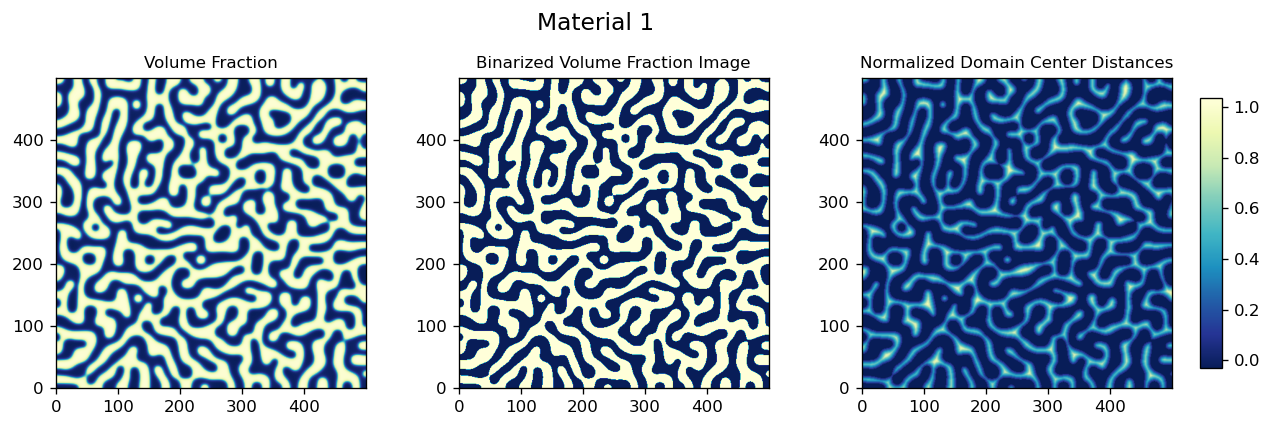

In [8]:
plot_arr(1)

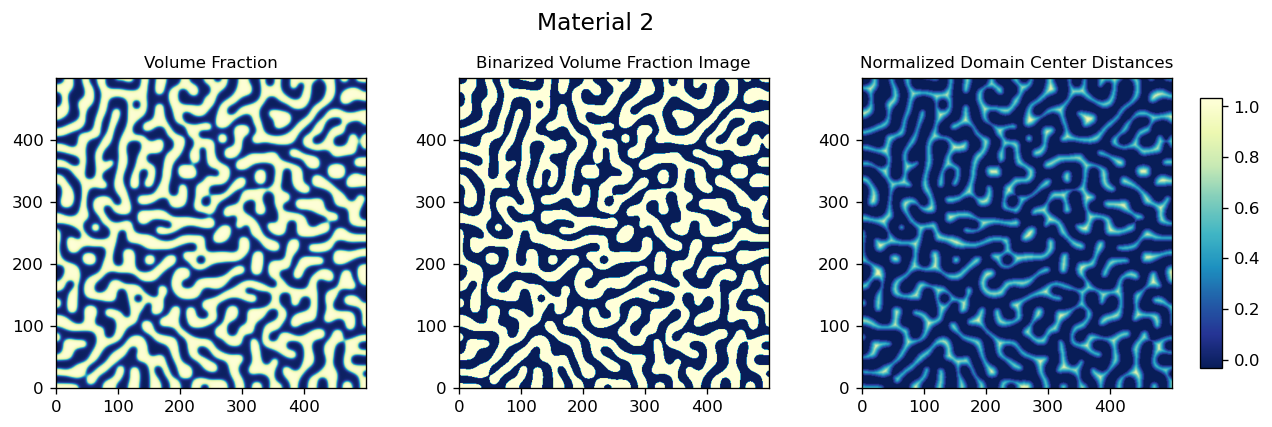

In [8]:
plot_arr(2)

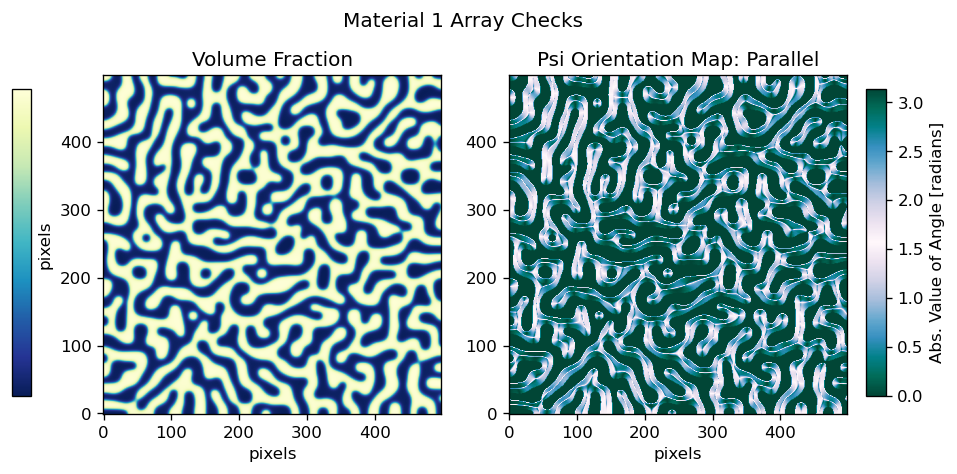

In [11]:
plot_psi(1)

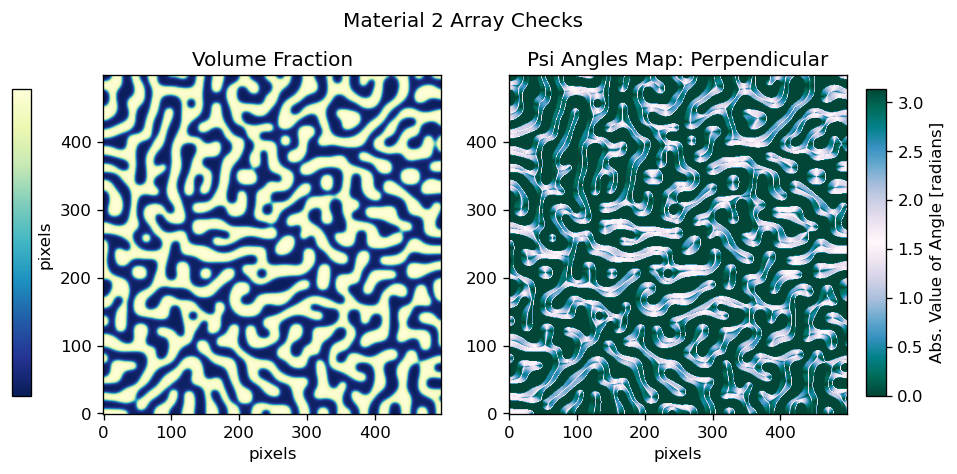

In [10]:
plot_psi(2)

--> Marking /nsls2/users/alevin/rsoxs_suite/imgs_analysis/sim_runs/D1.0_a1.0_eps1.0_250pix_375size_0.5m_600steps_1/BHJ.hdf5
Dataset dimensions (Z, Y, X): 1 x 500 x 500
Number of Materials: 2

Material 1 Vfrac. Min: -0.03108316265685794 Max: 1.0
Material 1 S. Min: 0.0 Max: 1.0
Material 1 theta. Min: 3.141592653589793 Max: 3.141592653589793
Material 1 psi. Min: -3.141573568952143 Max: 3.1414190536815654


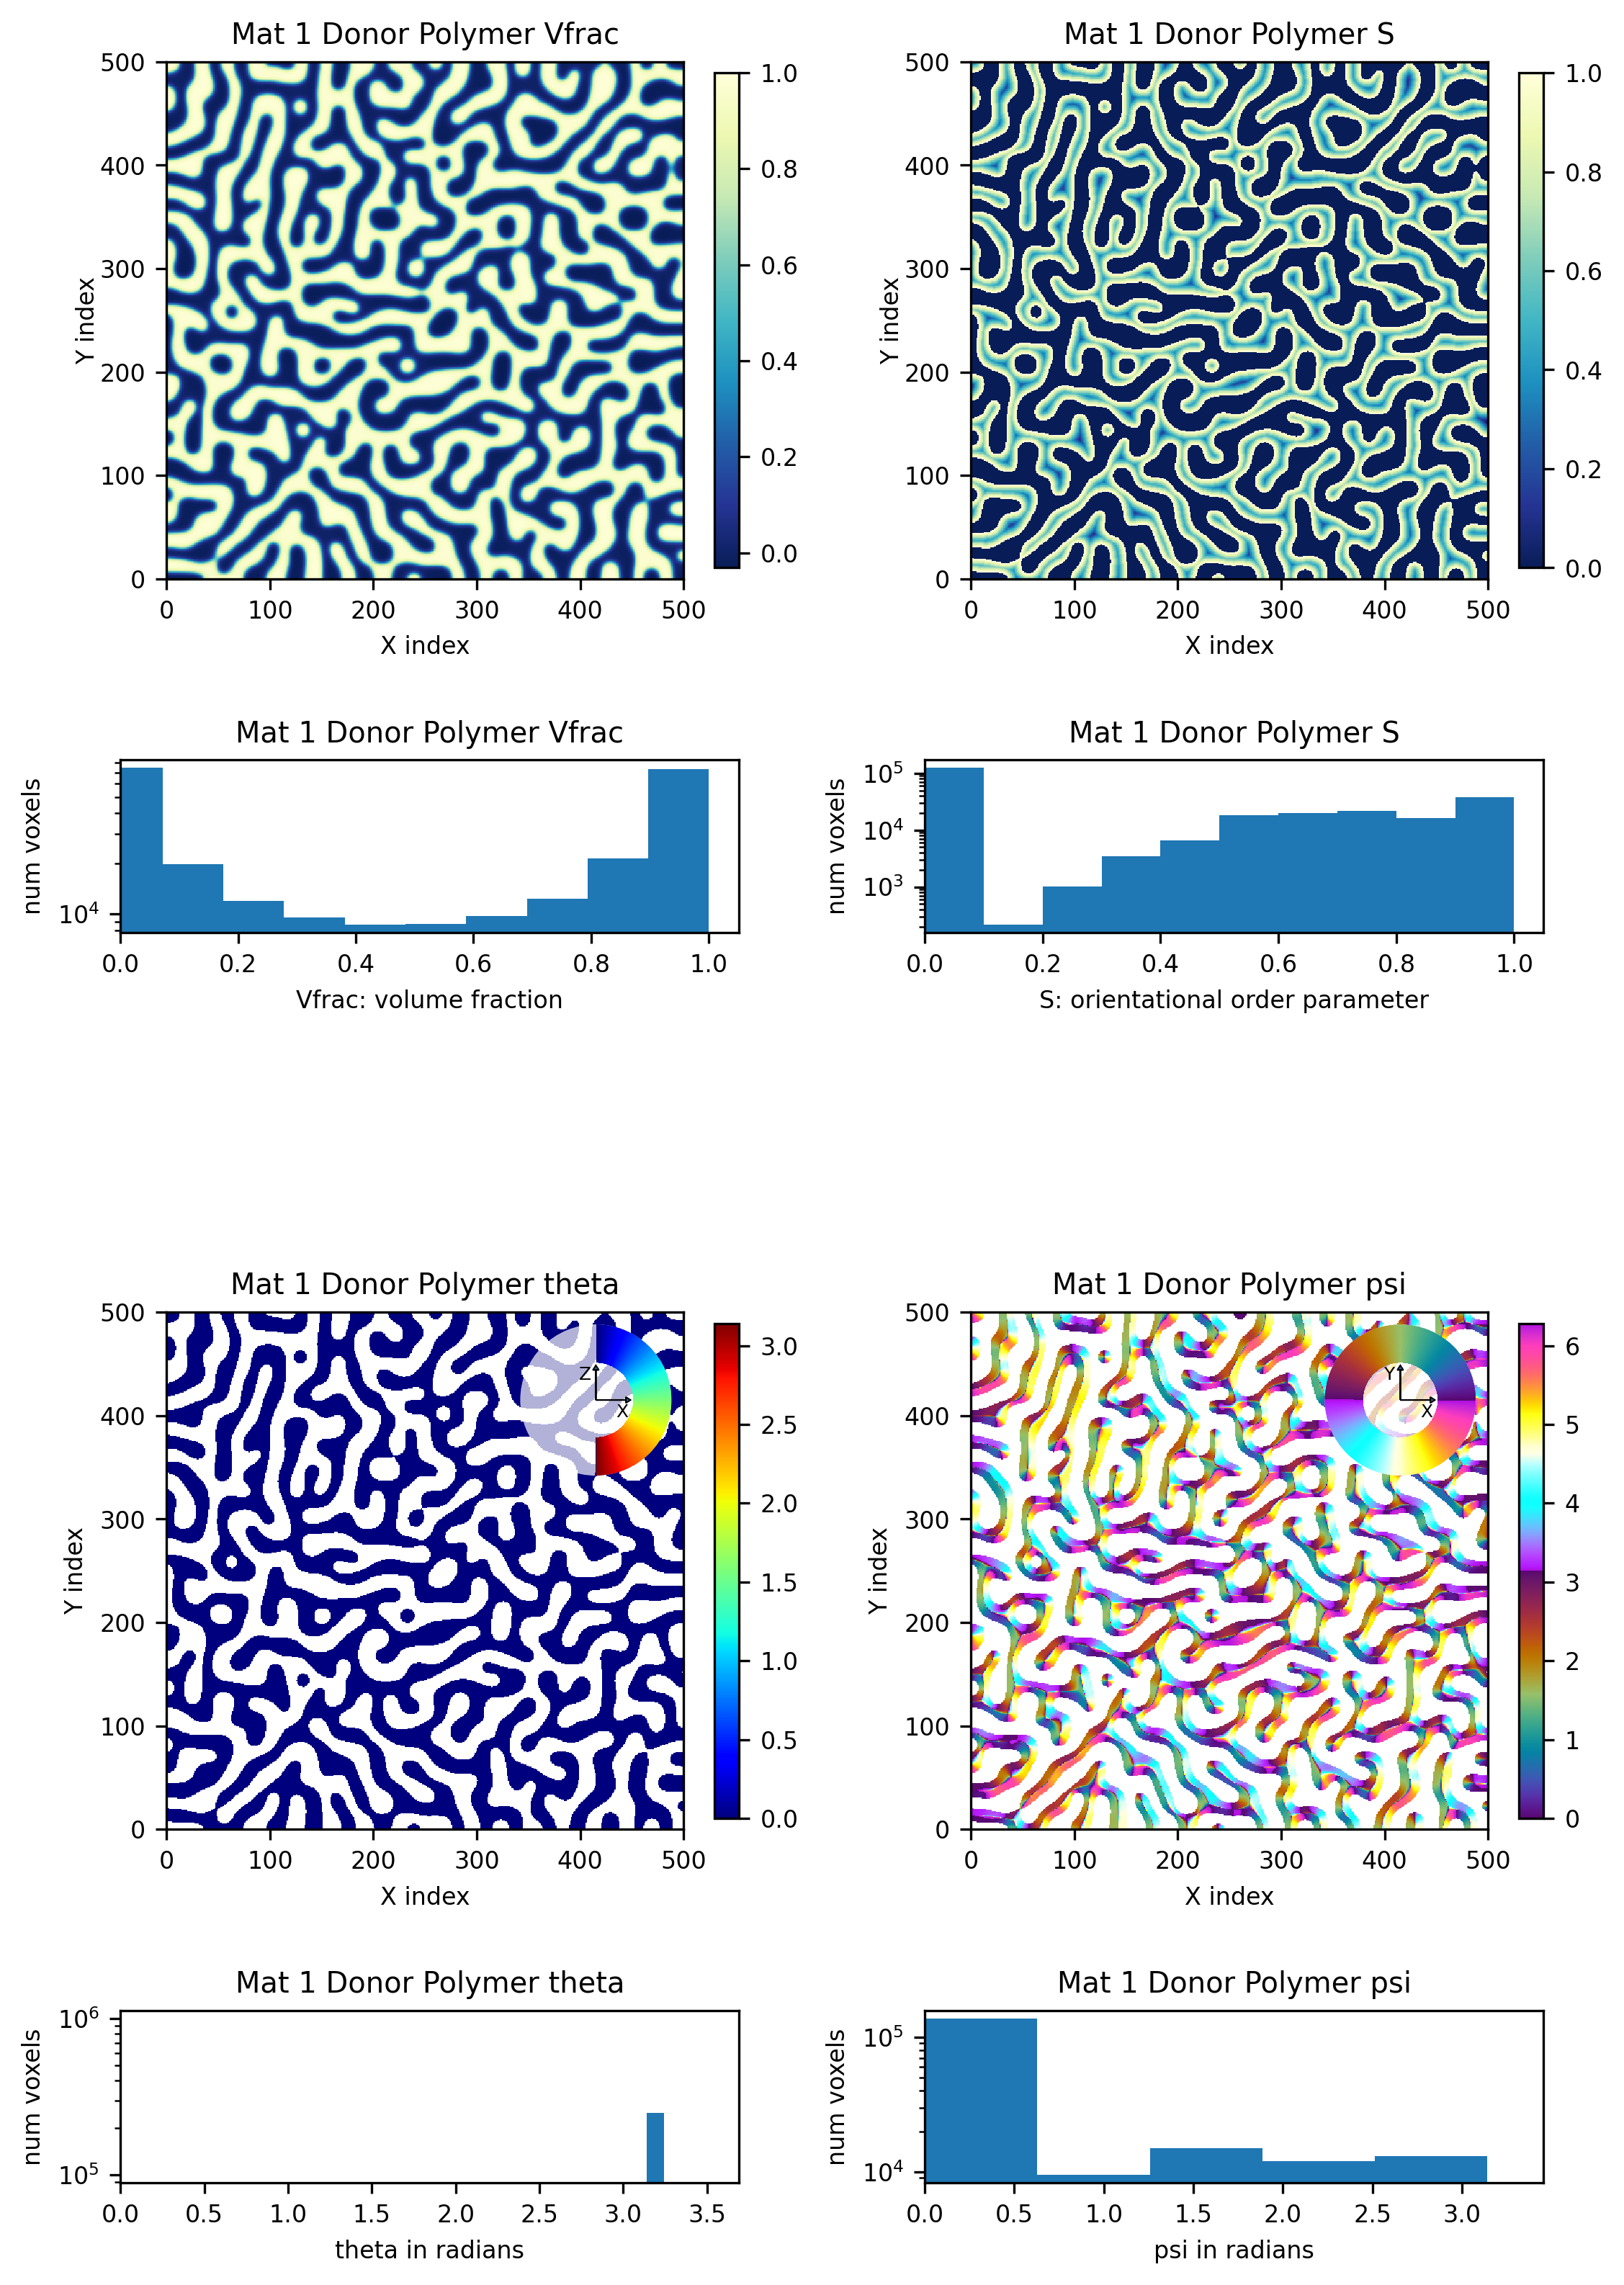

Material 2 Vfrac. Min: -0.03306649741664335 Max: 1.0
Material 2 S. Min: 0.0 Max: 0.9282041841382261
Material 2 theta. Min: 1.5707963267948966 Max: 1.5707963267948966
Material 2 psi. Min: -3.141582524653463 Max: 3.1415824200635036


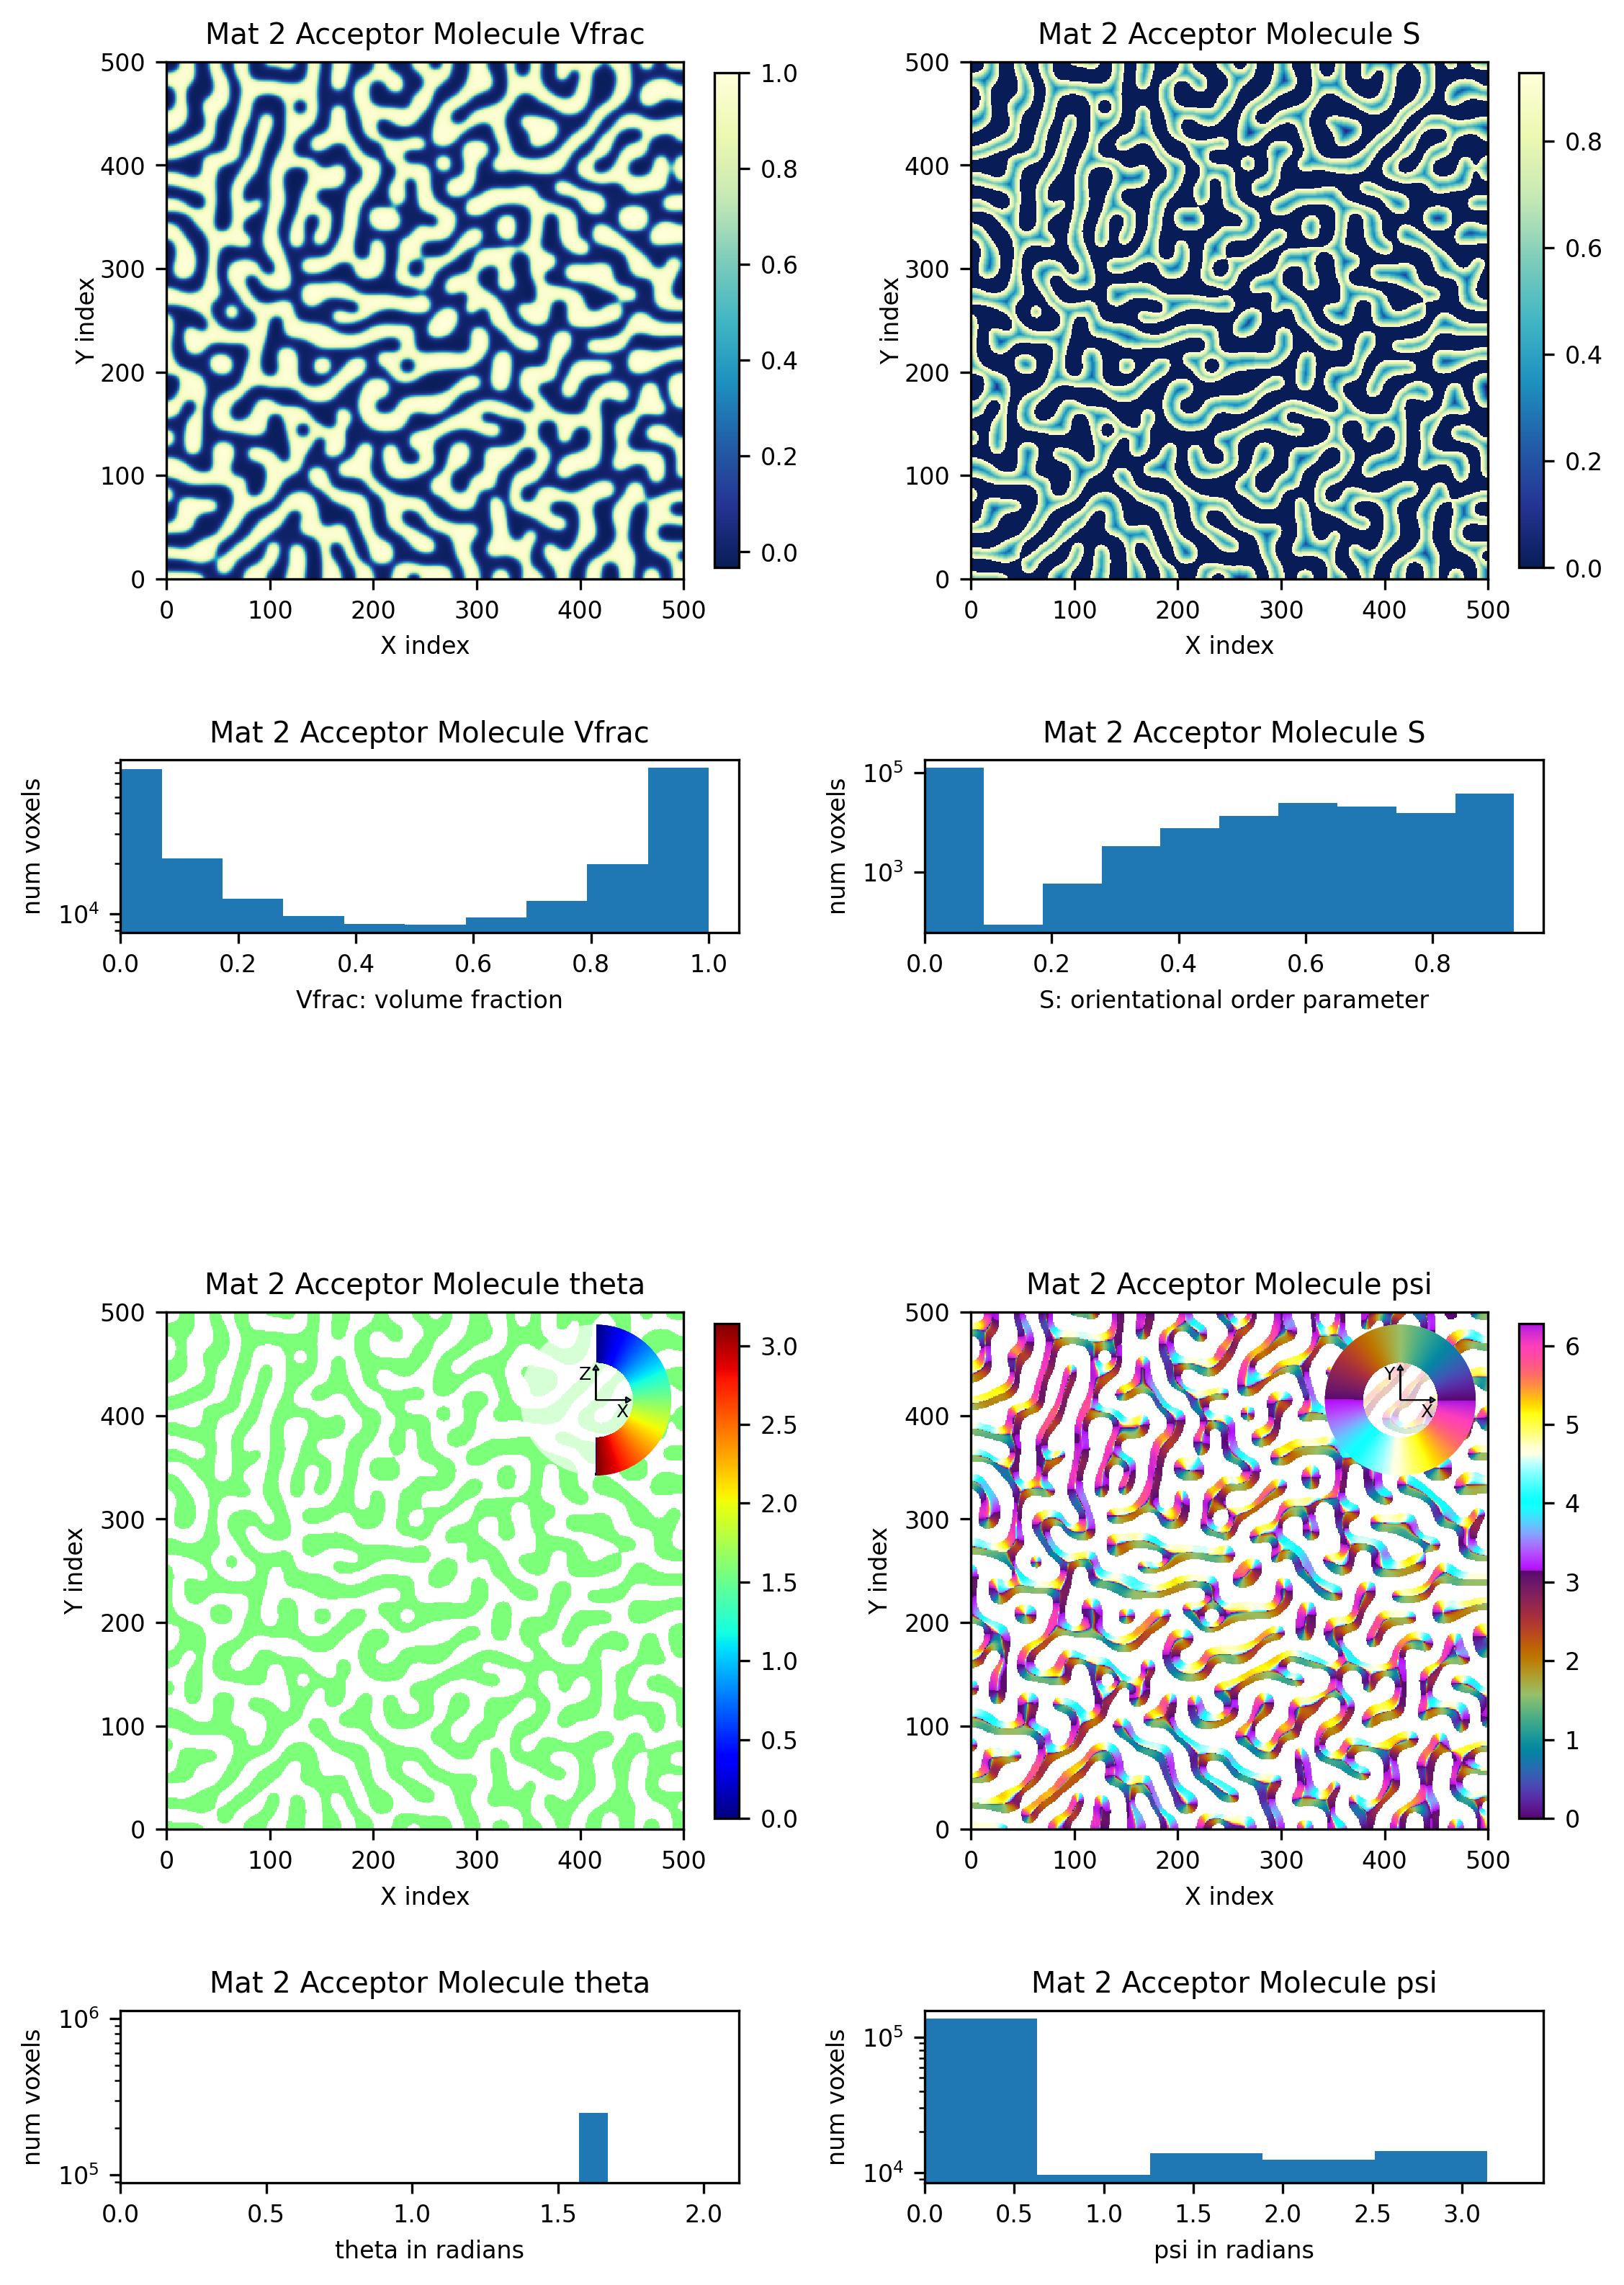

[]

<Figure size 640x480 with 0 Axes>

In [9]:
### Now write vfrac, psi, theta, and S:
pix = mat1_vfrac.shape[0]
mat1_Vfrac = (mat1_vfrac/np.max(mat1_vfrac)).reshape(1, pix, pix)

mat1_psi = mat1_angles_map.copy().reshape(1, pix, pix)
mat1_theta = (np.ones(mat1_vfrac.shape) * (np.pi)).reshape(1, pix, pix)
mat1_S = (1 - mat1_dist_transform/np.max(mat1_dist_transform)).reshape(1, pix, pix)
mat1_S[0,:,:][mat2_binary_image.astype('bool')] = 0
mat1_S = mat1_S/np.max(mat1_S)

mat2_Vfrac = (mat2_vfrac/np.max(mat2_vfrac)).reshape(1, pix, pix)
mat2_psi = mat2_angles_map.copy().reshape(1, pix, pix)
mat2_theta = (np.ones(mat2_vfrac.shape) * (np.pi/2)).reshape(1, pix, pix)
mat2_S = (1 - mat2_dist_transform/np.max(mat2_dist_transform)).reshape(1, pix, pix)
mat2_S[0,:,:][mat1_binary_image.astype('bool')] = 0
mat2_S = mat2_S/np.max(mat1_S)


### That was easy, now write to hdf5:
write_hdf5([
            [mat1_Vfrac, mat1_S, mat1_theta, mat1_psi],
            [mat2_Vfrac, mat2_S, mat2_theta, mat2_psi]
            ],
            5.0,
            simPath.joinpath('BHJ.hdf5'))

morph_obj = Morphology.load_morph_hdf5(simPath.joinpath('BHJ.hdf5'))
morph_obj.materials[1].name = 'Donor Polymer'
morph_obj.materials[2].name = 'Acceptor Molecule'
morphology_visualizer(morph_obj, vfrac_cmap=sequential_map, S_cmap=sequential_map)

In [94]:
write_materials??

Signature: write_materials(energies, materialdict, labelEnergy, numMaterial)
Source:   
def write_materials(energies, materialdict, labelEnergy, numMaterial):
    """
    Function to write optical constants for all energies supplied

    Parameters
    ----------

    energies : ndarray
    materialdict : dict
    labelEnergy : dict
    numMaterial : int


    """
    NumEnergy = len(energies)

    for numMat in range(1, numMaterial+1):
        f = open("Material" + str(numMat) + ".txt", "w")
        fname = materialdict["Material" + str(numMat)]
        if (fname != 'vacuum'):
            Data = np.loadtxt(fname, skiprows=1)
            Data = Data[Data[:, labelEnergy["Energy"]].argsort()]
            Data = removeDuplicates(Data, labelEnergy["Energy"])
            for i in range(0, NumEnergy):
                currentEnergy = energies[i]
                nearest_id = find_nearest(Data[:, labelEnergy["Energy"]], currentEnergy)
                ValArray = get_interpolated_value(Data, curr

In [106]:
### Now materials & config files:
os.chdir(simPath)

energies = np.round(np.arange(275,300,0.1),1)
material_dict = {'Material1': optsPath.joinpath('PM6_molecular.txt'), 
                 'Material2': optsPath.joinpath('Y6_molecular.txt')}
energy_dict = {
    'Energy': 0,
    'DeltaPara': 1,
    'BetaPara': 2,
    'DeltaPerp': 3,
    'BetaPerp': 4
}
write_materials(energies, material_dict, energy_dict, 2)
write_config(list(energies), [0.0, 1.0, 360.0])

In [107]:
simPath

PosixPath('/nsls2/users/alevin/rsoxs_suite/imgs_analysis/sim_runs/D1.0_a1.0_eps1.0_250pix_375size_0.5m_600steps_1')